Example of how to solve a simple tomography problem using pytorch.

PyTorch implementation of 
https://github.com/odlgroup/odl/blob/master/odl/contrib/tensorflow/examples/tensorflow_tomography.py

In this example, we solve the TV regularized tomography problem::

    min_x ||A(x) - b||_2^2 + 50 * ||grad(x)||_1

using a gradient descent method (ADAM).

In [1]:
import torch
import numpy as np
import odl
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output
from odl.contrib import torch as odl_torch

In [3]:
# Create ODL data structures
space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 360)
detector_partition = odl.uniform_partition(-60, 60, 512)
geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=40, det_radius=40)
ray_transform = odl.tomo.RayTransform(space, geometry)
grad = odl.Gradient(space)

In [4]:
# Create data
phantom = odl.phantom.shepp_logan(space, True)
data = ray_transform(phantom)
# noisy_data = data + odl.phantom.white_noise(data.space)
noisy_data = data

In [5]:
# Create pytorch layers from odl operators
ray_transform_layer = odl_torch.OperatorModule(ray_transform)
grad_layer = odl_torch.OperatorModule(grad)
x = Variable(torch.zeros(space.shape), requires_grad=True)

In [6]:
# Create constant right hand side
y = torch.tensor(np.asarray(noisy_data))

In [7]:
# Add empty axes for batch and channel
x_reshaped = Variable(torch.tensor(np.zeros(space.shape)[None, None, ...]), requires_grad=True)
y_reshaped = y[None, None, ...]

In [15]:
y_reshaped.shape

torch.Size([1, 1, 360, 512])

In [8]:
# Define loss function
# https://saturncloud.io/blog/custom-loss-function-in-pytorch-a-comprehensive-guide/#:~:text=A%20custom%20loss%20function%20in,and%20implementing%20the%20forward%20method.
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, x_reshaped, y_reshaped):
        loss = (torch.sum((ray_transform_layer(x_reshaped) - y_reshaped) ** 2) +
        50 * (torch.sum(torch.abs(grad_layer(x_reshaped)))))
        return loss.mean()

In [9]:
anim = []
# Utilize loss function and optimizer
x_reshaped = Variable(torch.tensor(np.zeros(space.shape)[None, None, ...]), requires_grad=True)
loss_fn = CustomLoss()
optimizer = torch.optim.Adam([x_reshaped], lr=1e-2)
for epoch in range(0,300):
    # Forward pass
    loss = loss_fn(x_reshaped, y_reshaped)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 9:
        anim.append(np.squeeze(x_reshaped.detach().numpy()))

    reconstructed_image = space.element(np.squeeze(x_reshaped.detach().numpy()))
    #clear_output(wait=True)
    #reconstructed_image.show(title=('iteration ' + str(epoch)))

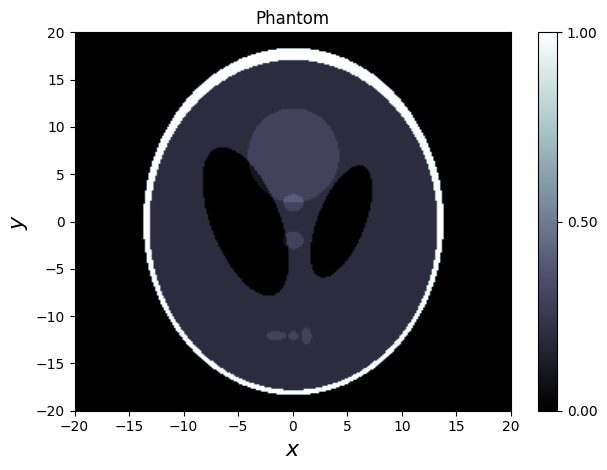

<Figure size 640x480 with 0 Axes>

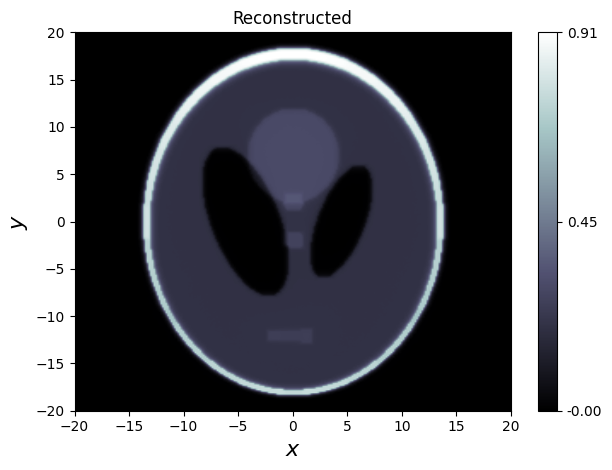

<Figure size 640x480 with 0 Axes>

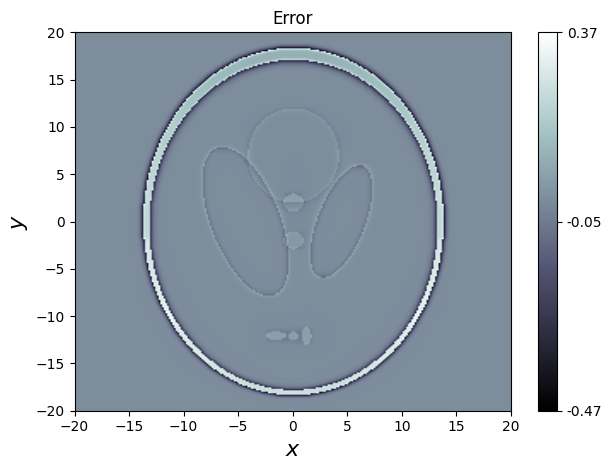

<Figure size 640x480 with 0 Axes>

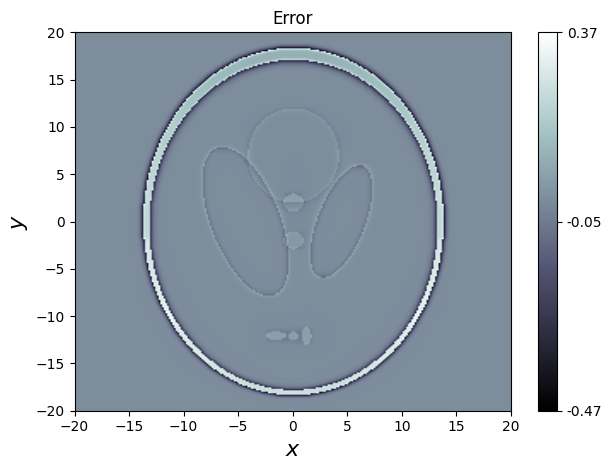

In [10]:
phantom.show(title='Phantom')
reconstructed_image.show(title='Reconstructed')
(phantom - reconstructed_image).show(title='Error')

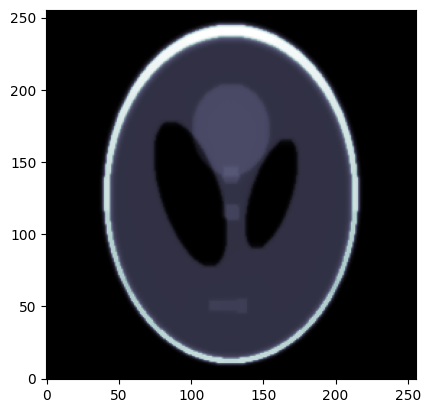

In [11]:
plt.imshow(np.transpose(anim[0]), cmap='bone', origin='lower')

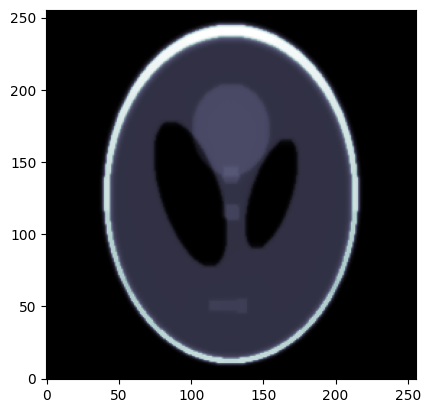

In [13]:
plt.imshow(np.transpose(anim[29]), cmap='bone', origin='lower')